# 0) Import des Librairies

---



In [ ]:
#pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [75]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\edmee\AppData\Local\Temp\ipykernel_14528\1233923705.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [34]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

In [113]:
import zipfile

In [114]:

chemin_zip = './Data/donnee_ts.zip'
dossier_extraction = './Data'

with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
    zip_ref.extractall(dossier_extraction)

In [115]:
df=pd.read_csv('./Data/donnee_ts.csv')
del df["Unnamed: 0"]

C:\Users\edmee\AppData\Local\Temp\ipykernel_14528\93771330.py:1: DtypeWarning:

Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.



# Stations

In [10]:
a=df.groupby(["libelle_departement", "code_cours_eau","code_station"]).agg({"resultat_obs_elab": "count" })

In [17]:
df["code_station"].nunique()

711

On a 711 stations à étudier. 
Nous allons commencer par nous focaliser sur celle avec le plus de data

In [120]:
nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)
nb_values

code_station
E642601001    6862
A325021001    6862
B532201001    6862
H224000501    6862
A243003001    6862
              ... 
B423000102      27
A664031001      27
1221000101      24
B700001002      13
F400000101       6
Name: resultat_obs_elab, Length: 711, dtype: int64

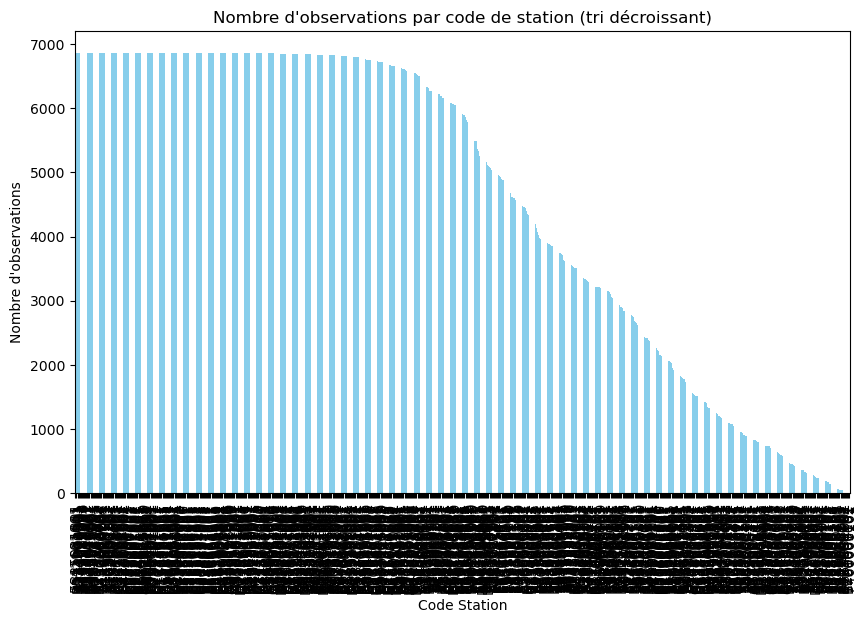

In [121]:


nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
nb_values.plot(kind='bar', color='skyblue')

plt.xlabel('Code Station')
plt.ylabel('Nombre d\'observations')
plt.title('Nombre d\'observations par code de station (tri décroissant)')

plt.show()


In [33]:
# nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
# big_station=nb_values[nb_values>5000]
# df = df[df["code_station"].isin(big_station.index)]

# Fonctions de visualisaiton 

Pour visualiser les données

In [122]:
def visu(ts):
    nom_station = ts["libelle_station"].iloc[0]
    
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])
    
    # Tracé d'un graphique temporel
    plt.figure(figsize=(15, 6))
    plt.plot(ts["date_obs_elab"], ts["resultat_obs_elab"], linewidth=3)
    plt.title(f'Stations {nom_station}')
    plt.show()

    # Histogramme
    fig = px.histogram(ts, x="resultat_obs_elab")
    fig.update_layout(title=f'Stations {nom_station}')
    fig.show()  

    # Box plot mensuel
    ts['Mois'] = ts['date_obs_elab'].dt.month_name()
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Mois', y='resultat_obs_elab', data=ts)
    plt.xlabel('Mois')
    plt.ylabel('Résultat Observation Elab')
    plt.title(f'Stations {nom_station}')
    plt.xticks(rotation=45)
    plt.show()



# Fonction de mise en forme

In [70]:
def mise_en_forme(ts):
    ts=ts[['date_obs_elab','resultat_obs_elab']]
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])

    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]
   
    train_r=train.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})

    test_r=test.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})
    return train_r, test_r

# Modele

Création du modèle, et on utilise le modèle sur la base test

In [73]:
def model(train_r,test_r):
    model = Prophet(
    yearly_seasonality=12,  # Increase the number of Fourier terms
    seasonality_prior_scale=0.8,  # Adjust the seasonality prior scale
    )

    model.fit(train_r)  
    test_fcst = model.predict(df=test_r)
    return (model, test_fcst)

Visualisation des données forecaster du modèle

In [127]:
def visu_ts( test_r,test_fcst, model ):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r')
    fig = model.plot(test_fcst, ax=ax)

In [128]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def erreur(test_r, test_fcst):
    a=mean_absolute_percentage_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    b=mean_absolute_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    print(f"Erreur moyenne absolue: {b} \nPOurcentage moyen de l'erreur absolue: {a}")
    

# Serie 

In [123]:
#Choix de la station
data=df[df["code_station"]=="A325021001"]

In [124]:
def construction_ts(station):
    visu(station)

    #mise en forme et séparation train/test
    train,test=mise_en_forme(station)

    modele, prediction = model(train,test)

    visu_ts(test,prediction, modele )

    erreur(test, prediction)
    return(prediction)

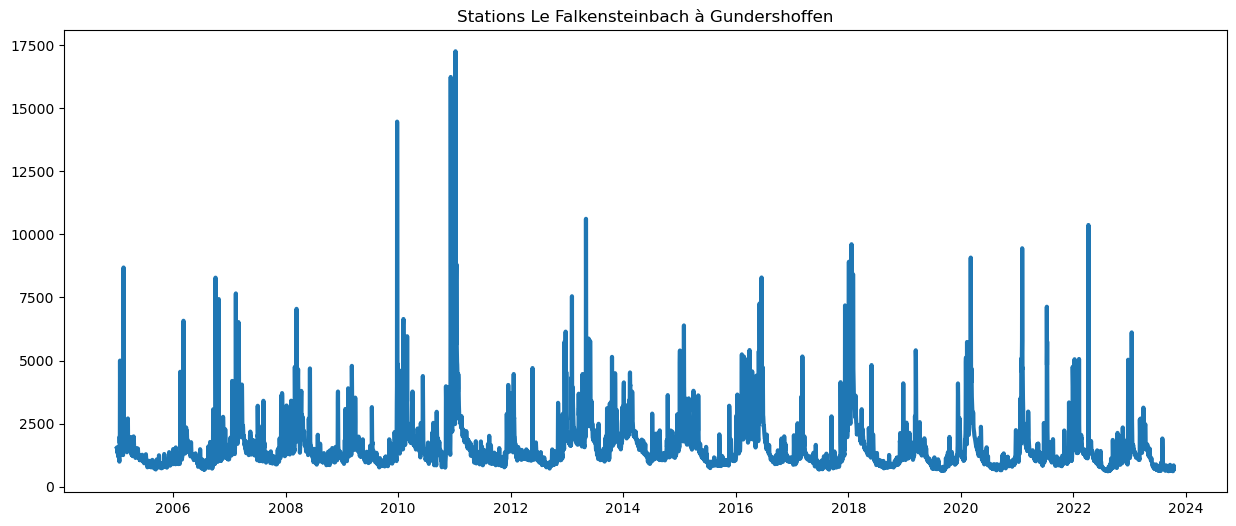

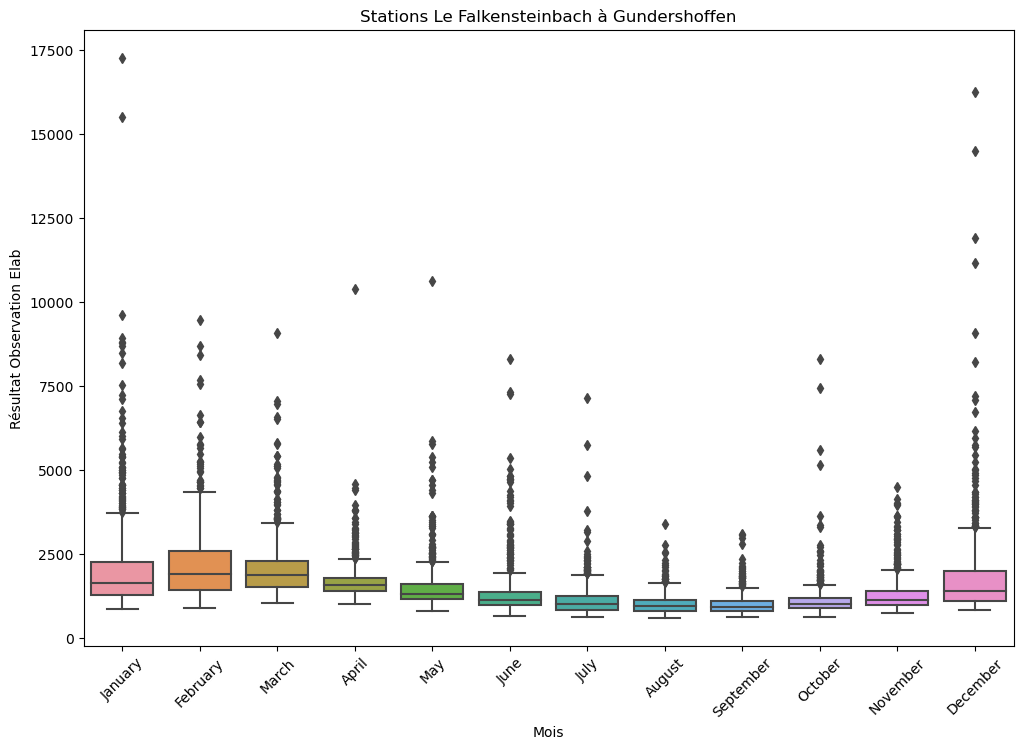

22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:22 - cmdstanpy - INFO - Chain [1] done processing


Erreur moyenne absolue: 445.7531166611762 
POurcentage moyen de l'erreur absolue: 28.9819568779925


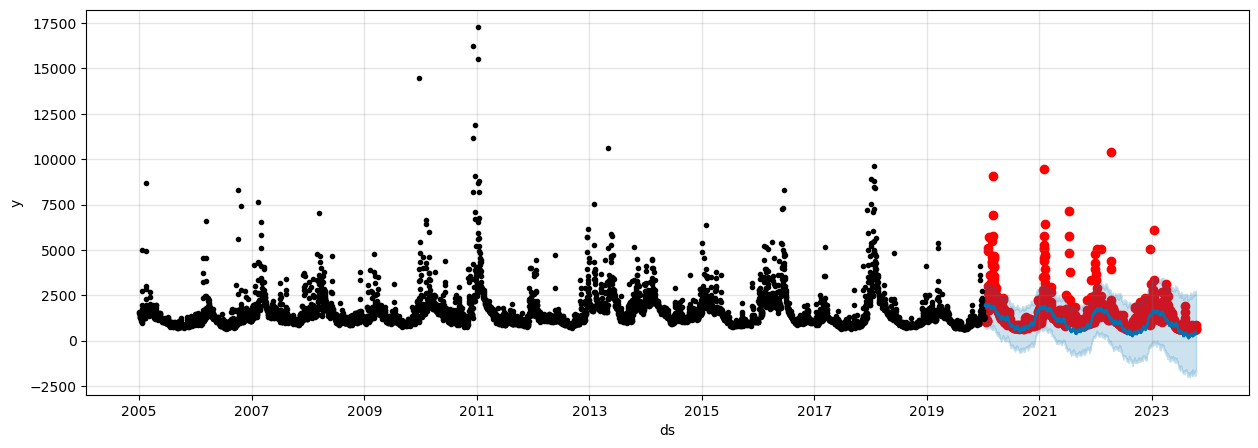

In [125]:
pred=construction_ts(data)


Pour récuper uniquement les données prédites par le modèle

In [112]:
predictions=pred[["ds", "yhat"]]
predictions

,ds,yhat
0,2020-01-12,3692.027778
1,2020-01-13,3695.282721
2,2020-01-14,3701.419062
3,2020-01-15,3687.678873
4,2020-01-16,3682.819112
...,...,...
1368,2023-10-11,3484.434919
1369,2023-10-12,3464.211830
1370,2023-10-13,3463.418587
1371,2023-10-14,3451.126642
